# Prepare github data
It is necessary to run when you running in google colab

In [1]:
# !git clone https://github.com/andriygav/SampleSizeLib
# !pip install SampleSizeLib/src
# !git clone https://github.com/ttgadaev/SampleSizeEstimation.git
# !mv SampleSizeEstimation/datasets datasets
# !mv SampleSizeEstimation/dumps dumps

# Import packages

In [2]:
import pandas as pd
import numpy as np
import pickle
from sklearn.preprocessing import scale
import matplotlib.pyplot as plt

In [3]:
from samplesizelib.linear.statistical import LagrangeEstimator
from samplesizelib.linear.statistical import LikelihoodRatioEstimator
from samplesizelib.linear.statistical import WaldEstimator

from samplesizelib.linear.heuristic import CrossValidationEstimator
from samplesizelib.linear.heuristic import BootstrapEstimator
from samplesizelib.linear.heuristic import LogisticRegressionEstimator

from samplesizelib.linear.bayesian import APVCEstimator
from samplesizelib.linear.bayesian import ACCEstimator
from samplesizelib.linear.bayesian import ALCEstimator
from samplesizelib.linear.bayesian import MaxUtilityEstimator
from samplesizelib.linear.bayesian import KLEstimator

from samplesizelib.linear.models import RegressionModel
from samplesizelib.linear.models import LogisticModel

In [4]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

In [5]:
from matplotlib import gridspec
from mpl_toolkits.mplot3d import Axes3D

import matplotlib.ticker as ticker
import locale

locale.setlocale(locale.LC_ALL, 'de_DE')

plt.rcParams["font.family"] = 'Djvu Serif'

plt.rcParams['text.usetex'] = True

plt.rcParams['text.latex.unicode'] = True

plt.rcParams['text.latex.preamble'] = [r'\usepackage[utf8x]{inputenc}', 
                                       r'\usepackage[english,russian]{babel}', 
                                       r'\usepackage{amsmath}',
                                       r'\usepackage{amsfonts}']

plt.rcParams['lines.linewidth'] = 6
plt.rcParams['lines.markersize'] = 6
plt.rcParams['xtick.labelsize'] = 36
plt.rcParams['ytick.labelsize'] = 36
plt.rcParams['legend.fontsize'] = 36
plt.rcParams['axes.titlesize']=36
plt.rcParams['axes.labelsize']=36
plt.rcParams['figure.figsize'] = (16.0, 8.0)
plt.rcParams['font.size'] = 40

plt.rcParams['axes.formatter.use_locale'] = True

# Experiment config for all models

In [6]:
NAME_TO_MODEL = {
    'LagrangeEstimator': LagrangeEstimator, 
    'LikelihoodRatioEstimator': LikelihoodRatioEstimator, 
    'WaldEstimator': WaldEstimator, 
    'CrossValidationEstimator': CrossValidationEstimator, 
    'BootstrapEstimator': BootstrapEstimator, 
    'LogisticRegressionEstimator': LogisticRegressionEstimator, 
    'APVCEstimator': APVCEstimator, 
    'ACCEstimator': ACCEstimator, 
    'ALCEstimator': ALCEstimator, 
    'ALCEstimator': ALCEstimator, 
    'MaxUtilityEstimator': MaxUtilityEstimator, 
}

config = {
    'LagrangeEstimator': {'epsilon': 0.2, 
                          'alpha': 0.05, 
                          'beta': 0.2},
    'LikelihoodRatioEstimator': {'epsilon': 0.2, 
                                 'alpha': 0.05, 
                                 'beta': 0.2},
    'WaldEstimator': {'epsilon': 0.2, 
                      'alpha': 0.05, 
                      'beta': 0.2},
    'BootstrapEstimator': {'averaging': 10,
                           'epsilon': 0.5, 
                           'multiprocess': True, 
                           'progressbar': True},
    'CrossValidationEstimator': {'averaging': 100,
                                 'test_size': 0.5, 
                                 'epsilon': 0.05, 
                                 'multiprocess': True, 
                                 'progressbar': True},
    'APVCEstimator': {'averaging': 100,
                      'epsilon': 0.5, 
                      'multiprocess': True, 
                      'progressbar': True},
    'ACCEstimator': {'averaging': 100,
                     'length': 0.25,
                     'alpha': 0.05, 
                     'multiprocess': True, 
                     'progressbar': True},
    'ALCEstimator': {'averaging': 100,
                     'length': 0.5,
                     'alpha': 0.05, 
                     'multiprocess': True, 
                     'progressbar': True},
    'MaxUtilityEstimator': {'averaging': 10,
                            'c': 0.005, 
                            'multiprocess': True, 
                            'progressbar': True},
}

In [7]:
def draw_table(data, title = ["PRECISION", "RECALL", "F-SCORE"], width = [20]*(1+3)):
    """
    data is a dict with format
        {row_name_1: (title[0], title[1], ...), 
         row_name_2: (title[0], title[1], ...), 
         ...}
    """
    print('#'*(sum(width) + len(width) + 1))
    
    row_format = '|' + '|'.join([("{:>"+str(w)+"}") for w in width]) + '|'
    row_format_between = '+' + '+'.join([("{:>"+str(w)+"}") for w in width]) + '+'
    
    print(row_format_between.format("-"*width[0], *["-"*width[i+1] for i, _ in enumerate(title)]))
    print(row_format.format("", *title))
    print(row_format_between.format("-"*width[0], *["-"*width[i+1] for i, _ in enumerate(title)]))
    for key in data:
        if len(key) > width[0]:
            row_name = '...' + key[len(key)-width[0]+3:]
        else:
            row_name = key
        print(row_format.format(row_name, *[round(x, 2) for x in data[key]]))
        print(row_format_between.format("-"*width[0], *["-"*width[i+1] for i, _ in enumerate(title)]))
    
    print('#'*(sum(width) + len(width) + 1))

# Boston Housing

## Load dataset

In [8]:
dataset = pd.read_csv('datasets/boston.csv')

y = dataset.iloc[:, dataset.columns == 'answer'].values.reshape(-1)
X = dataset.iloc[:, dataset.columns != 'answer'].values

X = scale(X)
y = scale(y)
X = np.hstack((X, np.ones([len(X), 1])))

## Prepara model

In [9]:
statmodel = RegressionModel

models = dict()
for key in config:
    models[key] = NAME_TO_MODEL[key](statmodel, **config[key])

## Using models for prediction

In [10]:
# result = dict()

# for i, key in enumerate(models):
#     result[key] = models[key](X, y)
#     print('{}: {}'.format(key, result[key]['m*']))

## Using dumps

In [11]:
# with open('dumps/ManyDatasetsExperiment/boston.pkl', 'wb') as f:
#     pickle.dump(result, f)

In [12]:
with open('dumps/ManyDatasetsExperiment/boston.pkl', 'rb') as f:
    result = pickle.load(f)

In [13]:
result_boston = result

## Rusult for Boston dataset

In [14]:
table_data = dict()
for key in result:
    table_data[key] = [result[key]['m*']]

draw_table(table_data, title=['m*'], width=[30, 20])

#####################################################
+------------------------------+--------------------+
|                              |                  m*|
+------------------------------+--------------------+
|             LagrangeEstimator|                  18|
+------------------------------+--------------------+
|      LikelihoodRatioEstimator|                  17|
+------------------------------+--------------------+
|                 WaldEstimator|                  66|
+------------------------------+--------------------+
|            BootstrapEstimator|                 178|
+------------------------------+--------------------+
|      CrossValidationEstimator|                 113|
+------------------------------+--------------------+
|                 APVCEstimator|                  98|
+------------------------------+--------------------+
|                  ACCEstimator|                 228|
+------------------------------+--------------------+
|                  ALCEstima

# Diabetes

## Load dataset

In [15]:
dataset = pd.read_csv('datasets/diabetes.csv')

y = dataset.iloc[:, dataset.columns == 'answer'].values.reshape(-1)
X = dataset.iloc[:, dataset.columns != 'answer'].values

X = scale(X)
y = scale(y)
X = np.hstack((X, np.ones([len(X), 1])))

## Prepara model

In [16]:
statmodel = RegressionModel

models = dict()
for key in config:
    models[key] = NAME_TO_MODEL[key](statmodel, **config[key])

## Using models for prediction

In [17]:
# result = dict()

# for i, key in enumerate(models):
#     result[key] = models[key](X, y)
#     print('{}: {}'.format(key, result[key]['m*']))

## Using dumps

In [18]:
# with open('dumps/ManyDatasetsExperiment/diabetes.pkl', 'wb') as f:
#     pickle.dump(result, f)

In [19]:
with open('dumps/ManyDatasetsExperiment/diabetes.pkl', 'rb') as f:
    result = pickle.load(f)

In [20]:
result_diabetes = result

## Rusult for Diabetes dataset

In [21]:
table_data = dict()
for key in result:
    table_data[key] = [result[key]['m*']]

draw_table(table_data, title=['m*'], width=[30, 20])

#####################################################
+------------------------------+--------------------+
|                              |                  m*|
+------------------------------+--------------------+
|             LagrangeEstimator|                  25|
+------------------------------+--------------------+
|      LikelihoodRatioEstimator|                  25|
+------------------------------+--------------------+
|                 WaldEstimator|                  51|
+------------------------------+--------------------+
|            BootstrapEstimator|                 441|
+------------------------------+--------------------+
|      CrossValidationEstimator|                 117|
+------------------------------+--------------------+
|                 APVCEstimator|                 167|
+------------------------------+--------------------+
|                  ACCEstimator|                 441|
+------------------------------+--------------------+
|                  ALCEstima

# Forest Fires

## Load dataset

In [22]:
dataset = pd.read_csv('datasets/forestfires.csv')

y = dataset.iloc[:, dataset.columns == 'answer'].values.reshape(-1)
X = dataset.iloc[:, dataset.columns != 'answer'].values

X = scale(X)
y = scale(y)
X = np.hstack((X, np.ones([len(X), 1])))

## Prepara model

In [23]:
statmodel = RegressionModel

models = dict()
for key in config:
    models[key] = NAME_TO_MODEL[key](statmodel, **config[key])

## Using models for prediction

In [24]:
# result = dict()

# for i, key in enumerate(models):
#     result[key] = models[key](X, y)
#     print('{}: {}'.format(key, result[key]['m*']))

## Using dumps

In [25]:
# with open('dumps/ManyDatasetsExperiment/forestfires.pkl', 'wb') as f:
#     pickle.dump(result, f)

In [26]:
with open('dumps/ManyDatasetsExperiment/forestfires.pkl', 'rb') as f:
    result = pickle.load(f)

In [27]:
result_forestfires = result

## Rusult for Forest Fires dataset

In [28]:
table_data = dict()
for key in result:
    table_data[key] = [result[key]['m*']]

draw_table(table_data, title=['m*'], width=[30, 20])

#####################################################
+------------------------------+--------------------+
|                              |                  m*|
+------------------------------+--------------------+
|             LagrangeEstimator|                  44|
+------------------------------+--------------------+
|      LikelihoodRatioEstimator|                  43|
+------------------------------+--------------------+
|                 WaldEstimator|                  46|
+------------------------------+--------------------+
|            BootstrapEstimator|                 171|
+------------------------------+--------------------+
|      CrossValidationEstimator|                  86|
+------------------------------+--------------------+
|                 APVCEstimator|                 351|
+------------------------------+--------------------+
|                  ACCEstimator|                 346|
+------------------------------+--------------------+
|                  ALCEstima

# Servo

## Load dataset

In [29]:
dataset = pd.read_csv('datasets/servo.csv')

y = dataset.iloc[:, dataset.columns == 'answer'].values.reshape(-1)
X = dataset.iloc[:, dataset.columns != 'answer'].values

X = scale(X)
y = scale(y)
X = np.hstack((X, np.ones([len(X), 1])))

## Prepara model

In [30]:
statmodel = RegressionModel

models = dict()
for key in config:
    models[key] = NAME_TO_MODEL[key](statmodel, **config[key])

## Using models for prediction

In [31]:
# result = dict()

# for i, key in enumerate(models):
#     result[key] = models[key](X, y)
#     print('{}: {}'.format(key, result[key]['m*']))

## Using dumps

In [32]:
# with open('dumps/ManyDatasetsExperiment/servo.pkl', 'wb') as f:
#     pickle.dump(result, f)

In [33]:
with open('dumps/ManyDatasetsExperiment/servo.pkl', 'rb') as f:
    result = pickle.load(f)

In [34]:
result_servo = result

## Rusult for Servo dataset

In [35]:
table_data = dict()
for key in result:
    table_data[key] = [result[key]['m*']]

draw_table(table_data, title=['m*'], width=[30, 20])

#####################################################
+------------------------------+--------------------+
|                              |                  m*|
+------------------------------+--------------------+
|             LagrangeEstimator|                  38|
+------------------------------+--------------------+
|      LikelihoodRatioEstimator|                  18|
+------------------------------+--------------------+
|                 WaldEstimator|                  76|
+------------------------------+--------------------+
|            BootstrapEstimator|                 120|
+------------------------------+--------------------+
|      CrossValidationEstimator|                  60|
+------------------------------+--------------------+
|                 APVCEstimator|                  20|
+------------------------------+--------------------+
|                  ACCEstimator|                  65|
+------------------------------+--------------------+
|                  ALCEstima

# NBA

## Load dataset

In [36]:
dataset = pd.read_csv('datasets/nba.csv')

y = dataset.iloc[:, dataset.columns == 'answer'].values.reshape(-1)
X = dataset.iloc[:, dataset.columns != 'answer'].values

X = scale(X)
X = np.hstack((X, np.ones([len(X), 1])))

## Prepara model

In [37]:
statmodel = LogisticModel

models = dict()
for key in config:
    models[key] = NAME_TO_MODEL[key](statmodel, **config[key])

## Using models for prediction

In [38]:
# result = dict()

# for i, key in enumerate(models):
#     result[key] = models[key](X, y)
#     print('{}: {}'.format(key, result[key]['m*']))

## Using dumps

In [39]:
# with open('dumps/ManyDatasetsExperiment/nba.pkl', 'wb') as f:
#     pickle.dump(result, f)

In [40]:
with open('dumps/ManyDatasetsExperiment/nba.pkl', 'rb') as f:
    result = pickle.load(f)

In [41]:
result_nba = result

## Rusult for NBA dataset

In [42]:
table_data = dict()
for key in result:
    table_data[key] = [result[key]['m*']]

draw_table(table_data, title=['m*'], width=[30, 20])

#####################################################
+------------------------------+--------------------+
|                              |                  m*|
+------------------------------+--------------------+
|             LagrangeEstimator|                 218|
+------------------------------+--------------------+
|      LikelihoodRatioEstimator|                 110|
+------------------------------+--------------------+
|                 WaldEstimator|                 200|
+------------------------------+--------------------+
|            BootstrapEstimator|                1328|
+------------------------------+--------------------+
|      CrossValidationEstimator|                 405|
+------------------------------+--------------------+
|                 APVCEstimator|                1328|
+------------------------------+--------------------+
|                  ACCEstimator|                1328|
+------------------------------+--------------------+
|                  ALCEstima

# Final result table for all dataset

In [43]:
table_data = dict()

result = result_boston
for key in result:
    if key in table_data:
        table_data[key] += [result[key]['m*']]
    else:
        table_data[key] = [result[key]['m*']]
        
result = result_diabetes
for key in result:
    if key in table_data:
        table_data[key] += [result[key]['m*']]
    else:
        table_data[key] = [result[key]['m*']]

result = result_forestfires
for key in result:
    if key in table_data:
        table_data[key] += [result[key]['m*']]
    else:
        table_data[key] = [result[key]['m*']]

result = result_servo
for key in result:
    if key in table_data:
        table_data[key] += [result[key]['m*']]
    else:
        table_data[key] = [result[key]['m*']]
        
result = result_nba
for key in result:
    if key in table_data:
        table_data[key] += [result[key]['m*']]
    else:
        table_data[key] = [result[key]['m*']]
        forestfires

draw_table(table_data, 
           title=['Boston m*', 'Diabetes m*', 'ForestFires m*', 'Servo m*', 'NBA m*'], 
           width=[25]+[15]*5)

###########################################################################################################
+-------------------------+---------------+---------------+---------------+---------------+---------------+
|                         |      Boston m*|    Diabetes m*| ForestFires m*|       Servo m*|         NBA m*|
+-------------------------+---------------+---------------+---------------+---------------+---------------+
|        LagrangeEstimator|             18|             25|             44|             38|            218|
+-------------------------+---------------+---------------+---------------+---------------+---------------+
| LikelihoodRatioEstimator|             17|             25|             43|             18|            110|
+-------------------------+---------------+---------------+---------------+---------------+---------------+
|            WaldEstimator|             66|             51|             46|             76|            200|
+-------------------------+-

## Graphs

In [44]:
def smooth(series, alpha=0.3):
    series_hat = [series[0]]
    for t in range(len(series)):
        series_hat.append(series_hat[t] + alpha*(series[t]- series_hat[t]))
    return series_hat[1:]

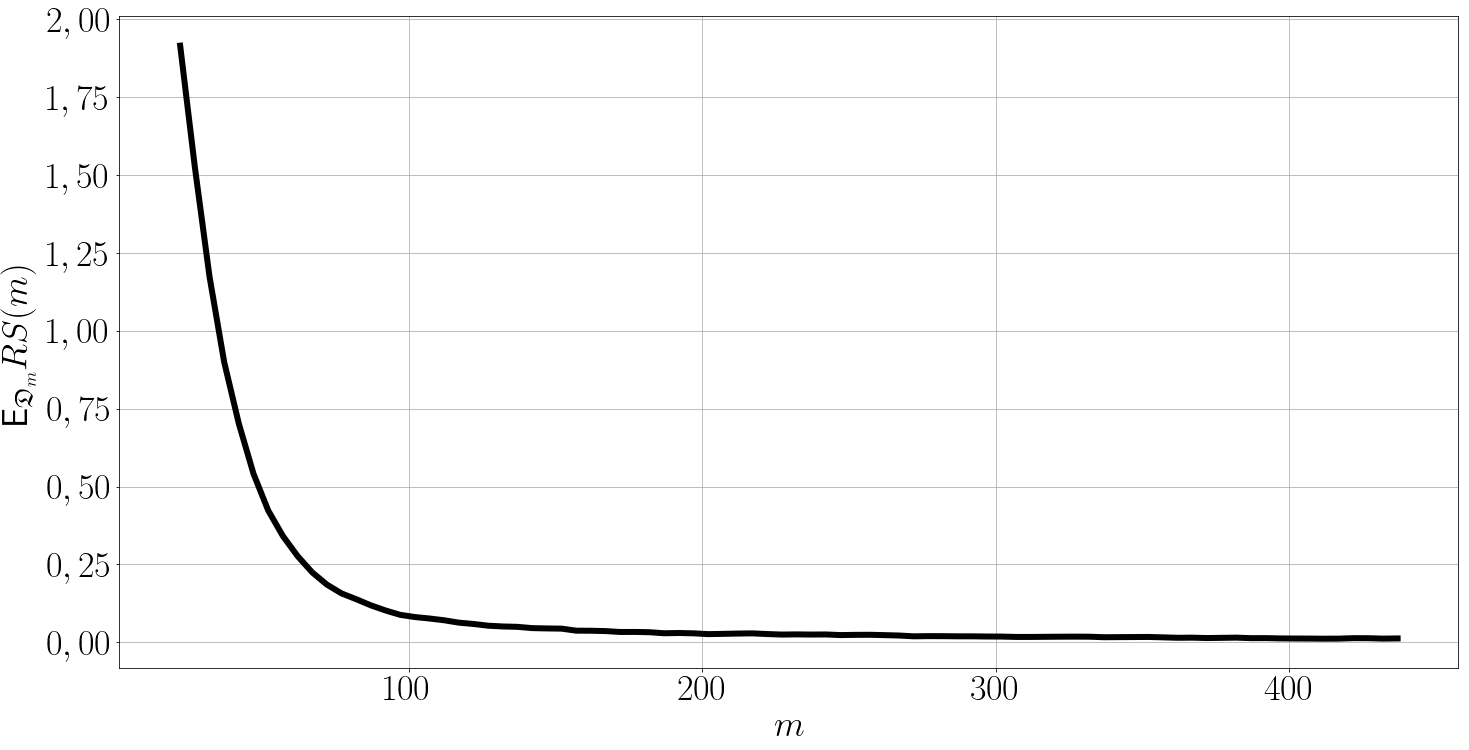

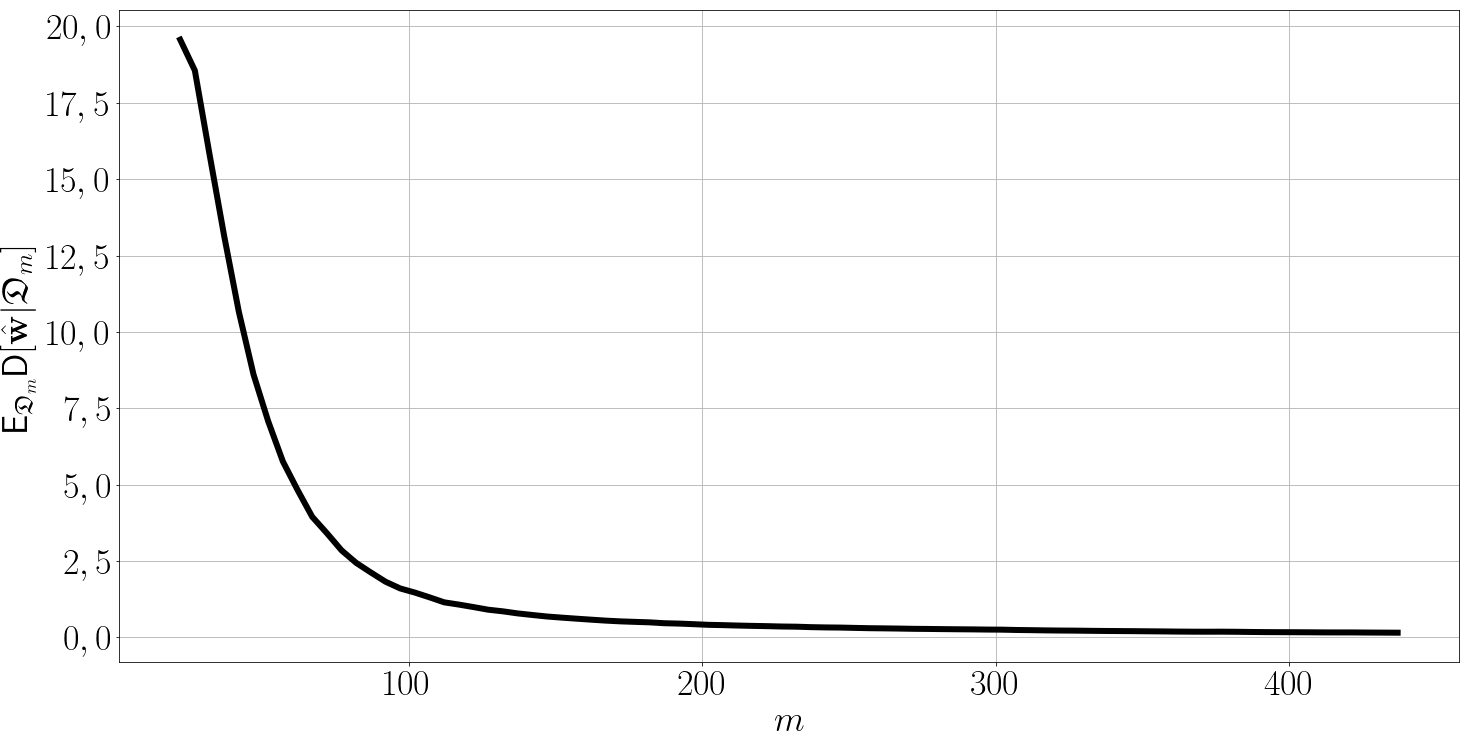

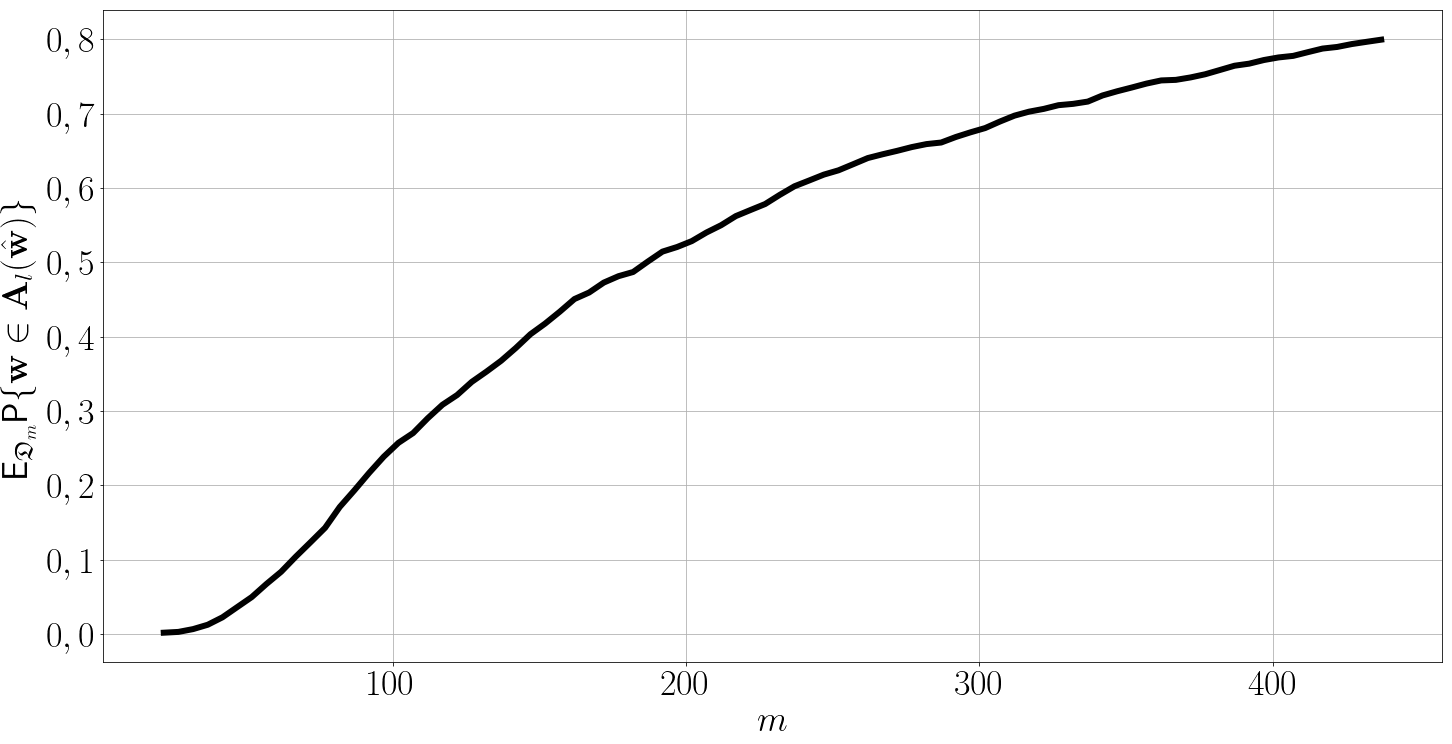

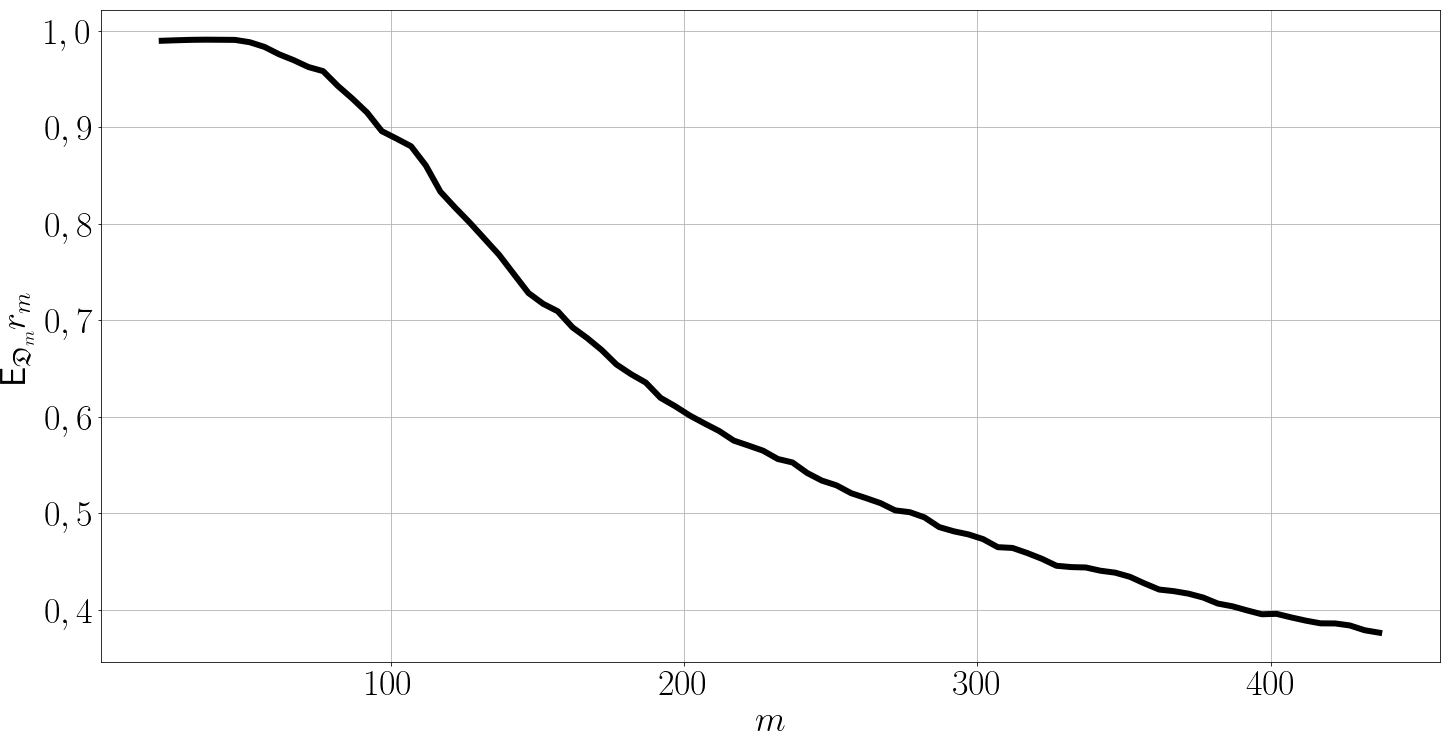

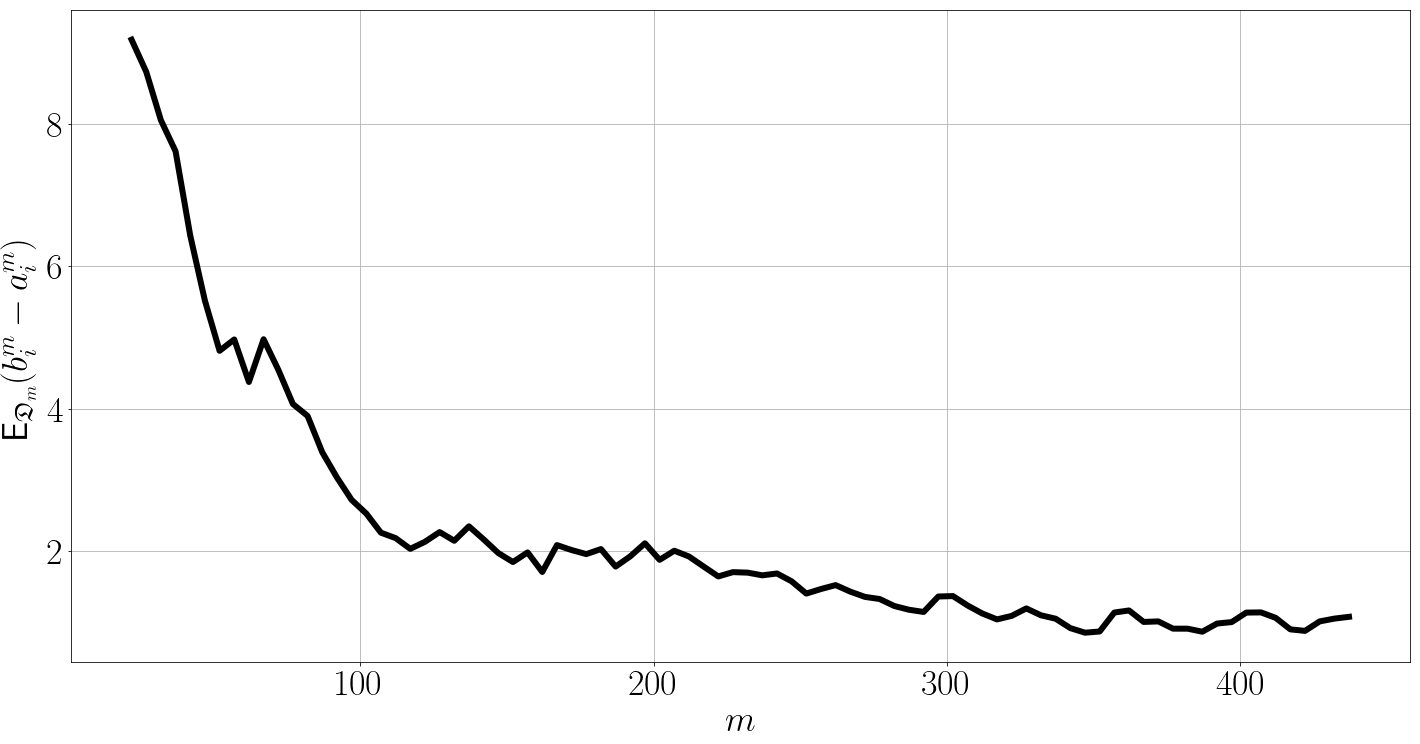

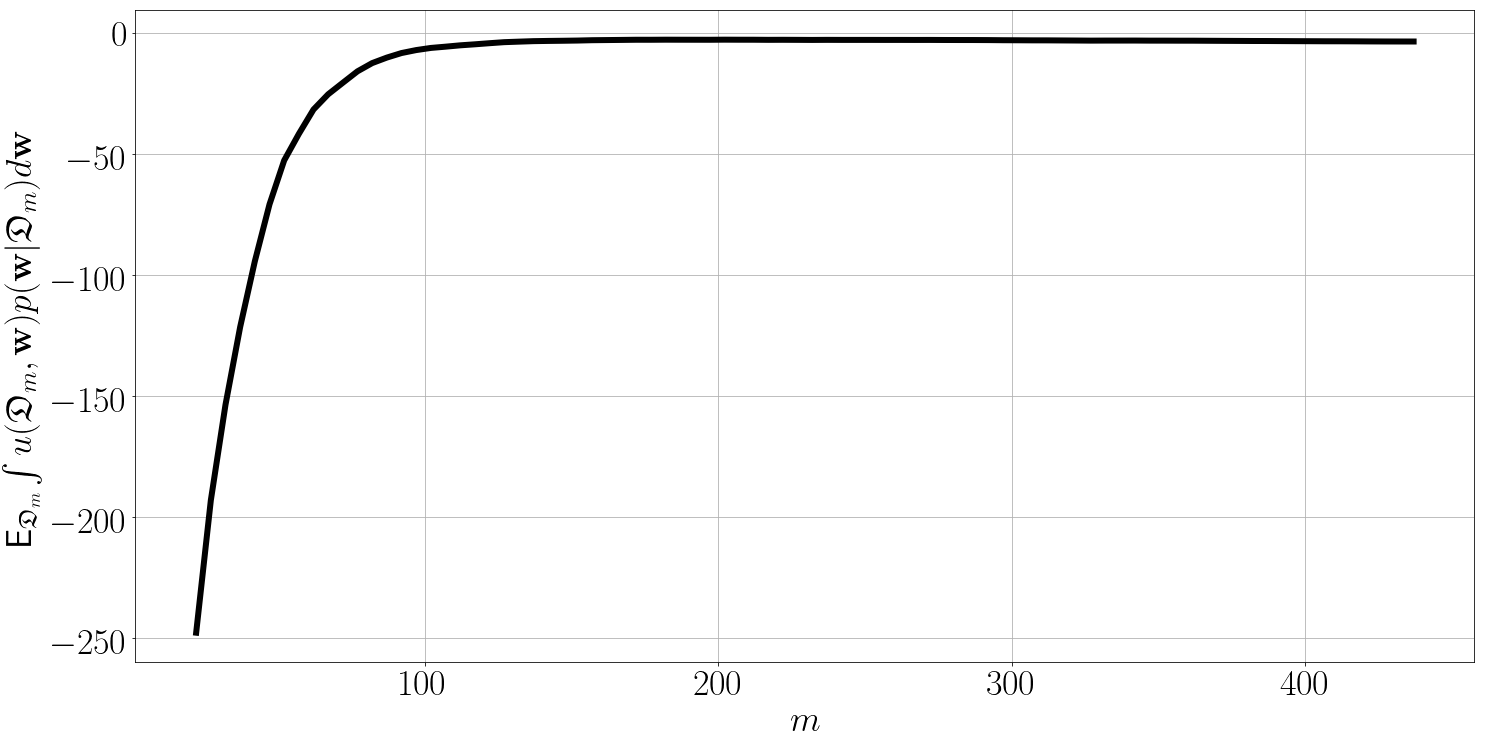

In [45]:
result = result_diabetes
graphs = ['CrossValidationEstimator', 
          'APVCEstimator', 
          'ACCEstimator', 
          'ALCEstimator', 
          'BootstrapEstimator', 
          'MaxUtilityEstimator']

lables = dict()
lables['CrossValidationEstimator'] = '$\mathsf{E}_{\mathfrak{D}_m}RS(m)$'
lables['APVCEstimator'] = '$\mathsf{E}_{\mathfrak{D}_m}\mathsf{D}[\hat{\mathbf{w}}|\mathfrak{D}_m]$'
lables['ACCEstimator'] = '$\mathsf{E}_{\mathfrak{D}_m}\mathsf{P}\{\mathbf{w}\in \mathbf{A}_{l}(\hat{\mathbf{w}})\}$'
lables['ALCEstimator'] = '$\mathsf{E}_{\mathfrak{D}_m}r_m$'
lables['BootstrapEstimator'] = '$\mathsf{E}_{\mathfrak{D}_m}(b_i^m - a_i^m)$'
lables['MaxUtilityEstimator'] = '$\mathsf{E}_{\mathfrak{D}_m}\int u(\mathfrak{D}_m, \mathbf{w})p(\mathbf{w}|\mathfrak{D}_m)d\mathbf{w}$'

names = dict()
names['CrossValidationEstimator'] = 'cross.eps'
names['APVCEstimator'] = 'apvc.eps'
names['ACCEstimator'] = 'acc.eps'
names['ALCEstimator'] = 'als.eps'
names['BootstrapEstimator'] = 'bootstrap.eps'
names['MaxUtilityEstimator'] = 'maxu.eps'

for key in graphs:
    x = result[key]['m']
    y = smooth(result[key]['E'])
    plt.plot(x, y, color='black')
    plt.xlabel('$m$')
    plt.ylabel(lables[key])
    plt.grid()
    plt.savefig(names[key], bbox_inches='tight')
    plt.show()